## **Importing libraries and data**

In [2]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

In [3]:
## Load ADS using name and path

load_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Master_Dataset/OMS_IPL_V1.csv', index_col=0)
load_ads = load_ads[load_ads.TR>0]
load_ads['CREATION_DATETIME'] = pd.to_datetime(load_ads['CREATION_DATETIME'], infer_datetime_format = True, errors = 'coerce')

# Getting info for training dataset
event_id = load_ads['EVENT']
outage_id = load_ads[['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                        'CIRCT_ID', 'SUBST_ID', 'ETR_DATETIME', 'Marker_Location', 'RANK_SUBSEQUENT_OUTAGES', 'LAT', 'LONG', 'Live_outage_group']]

# Dropping unnecessary columns
load_ads_v1 = load_ads.copy(deep=True)
load_ads_v1.drop(columns= ['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                        'ETR_DATETIME', 'Marker_Location', 'RANK_SUBSEQUENT_OUTAGES', 'LAT', 'LONG', 'Live_outage_group',
                        'Dis_From_Live_Centriod_div_Cust_qty'], inplace=True)
print(load_ads_v1.shape)
display(load_ads_v1.head())

(561196, 148)


,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,CUST_QTY,DAY_FLAG,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Time_Since_Outage,TR,Slope_outages,Slope_ROC_outages,max_ROC_outages,max_index_ROC,weight_ROC
0,3059.00,SSUB,305.00,4,177.00,1.00,177.00,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE3,7,1,5,2,1,0.71,0.71,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1.00,1.00,ARL.,92.00,100.00,44.00,33.90,39.50,30.00,30.30,36.70,24.30,38.50,43.70,34.50,1016.40,1026.00,1008.90,0.00,28.50,125.40,684.30,83.30,90.30,79.30,986.80,995.80,980.10,0.00,4.20,5.20,3.60,38.50,43.70,34.50,36.60,41.70,32.80,30.30,36.70,24.30,269.00,269.00,267.00,16.80,20.30,8.80,17.00,20.60,8.90,14.40,17.80,6.70,9.20,11.10,15.70,56.00,11.00,1.14,1.02,0.00,15.00,nan,nan,0,1,0.00
1,1958.00,1TBOH,195.00,2,6.00,0.00,6.00,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.71,-0.71,1,0,1,1,1,1,1,2,2,2,2,Monday,False,1.00,1.00,MILL,90.00,100.00,42.00,33.50,39.10,29.70,29.80,36.00,23.80,38.10,42.90,34.10,1016.70,1026.10,1009.30,0.00,29.50,130.10,707.00,83.70,90.00,79.00,987.90,996.80,981.30,0.00,4.10,5.20,3.50,38.10,42.90,34.10,36.20,41.10,32.40,29.80,36.00,23.80,269.00,269.00,267.00,16.60,20.30,8.80,16.80,20.50,8.90,14.30,17.80,6.70,8.80,11.10,15.50,58.00,11.00,1.14,1.02,0.00,39.60,4.02,-1.93,1,1,0.10
2,1958.00,1TBOH,195.00,2,6.00,0.00,6.00,True,False,False,False,True,False,False,False,True,False,False,Fa

In [4]:
print(list(load_ads_v1.columns))

['CIRCT_ID', 'DNI_EQUIP_TYPE', 'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'CUST_QTY', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG',

In [5]:
#Dropping the rows with NA values in Slope_ROC_outages & Slope_outages
load_ads.dropna(subset=['Slope_ROC_outages', 'Slope_outages'],inplace=True)
load_ads_v1.dropna(subset=['Slope_ROC_outages', 'Slope_outages'],inplace=True)

In [6]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

### **Distribution and transformation of Y-variable**

### **Target Variable Analysis: Is it Normal?**

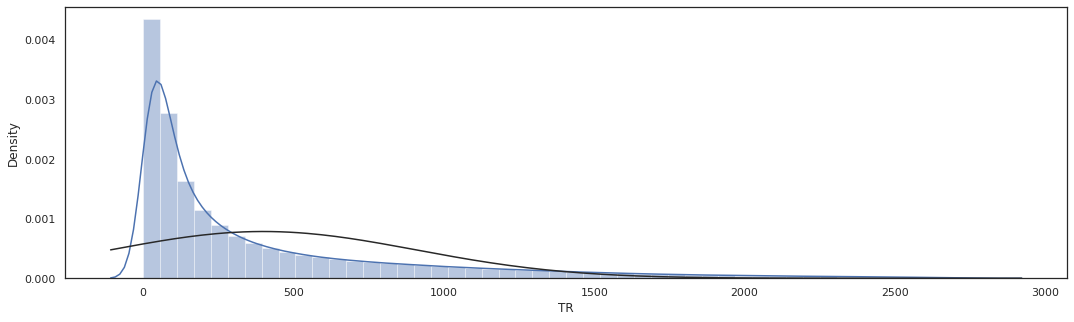

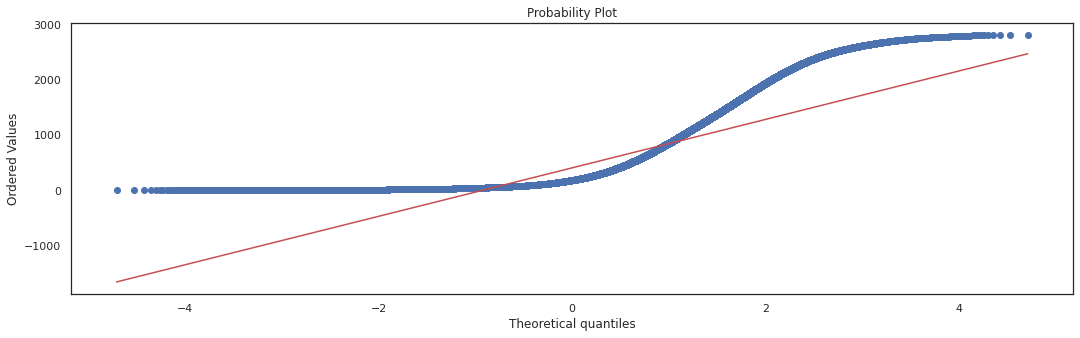

In [7]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,5)})
sns.set_style("white")

sns.distplot(load_ads_v1['TR'],fit=norm);
fig = plt.figure()
res = stats.probplot(load_ads_v1['TR'], plot=plt)

In [8]:
#Checking the columns having data type as object or boolean
object_columns = load_ads_v1.loc[:, (load_ads_v1.dtypes == object) | (load_ads_v1.dtypes == bool)]
print(list(object_columns.columns))

['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', '

In [9]:
#Converting data type of CIRCT_ID & SUBST_ID to integer
load_ads_v1['CIRCT_ID'] = load_ads_v1['CIRCT_ID'].astype(int)
load_ads_v1['SUBST_ID'] = load_ads_v1['SUBST_ID'].astype(int)

In [10]:
#Converting data type of CIRCT_ID & SUBST_ID to integer
load_ads['CIRCT_ID'] = load_ads['CIRCT_ID'].astype(int)
load_ads['SUBST_ID'] = load_ads['SUBST_ID'].astype(int)

In [ ]:
%%time

X = load_ads_v1.drop(['TR'],axis=1)
y = load_ads_v1['TR']

cat = CatBoostRegressor(silent = True)

cat.fit(X, y, cat_features=['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG',
                                                   'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG',
                                                   'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 
                                                   'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG',
                                                   'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                                                   'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 
                                                   'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                                                   'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 
                                                   'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 
                                                   'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 
                                                   'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 
                                                   'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0',
                                                   'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE',
                                                   'Weekday', 'Weekend_flag', 'Dispatch_Location', 'CIRCT_ID', 'SUBST_ID'])

CPU times: user 32min 20s, sys: 1min 18s, total: 33min 38s
Wall time: 5min 21s


In [12]:
catboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_CatBoost': cat.feature_importances_}).sort_values(by='Importance_Score_CatBoost',ascending=False)
catboost.reset_index(drop=True,inplace=True)
catboost = catboost.head(40)

In [13]:
catboost.to_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Model/IPL_TTR_Catboost_12082020.csv', index=False)

## **Feature Importance using CatBoost**

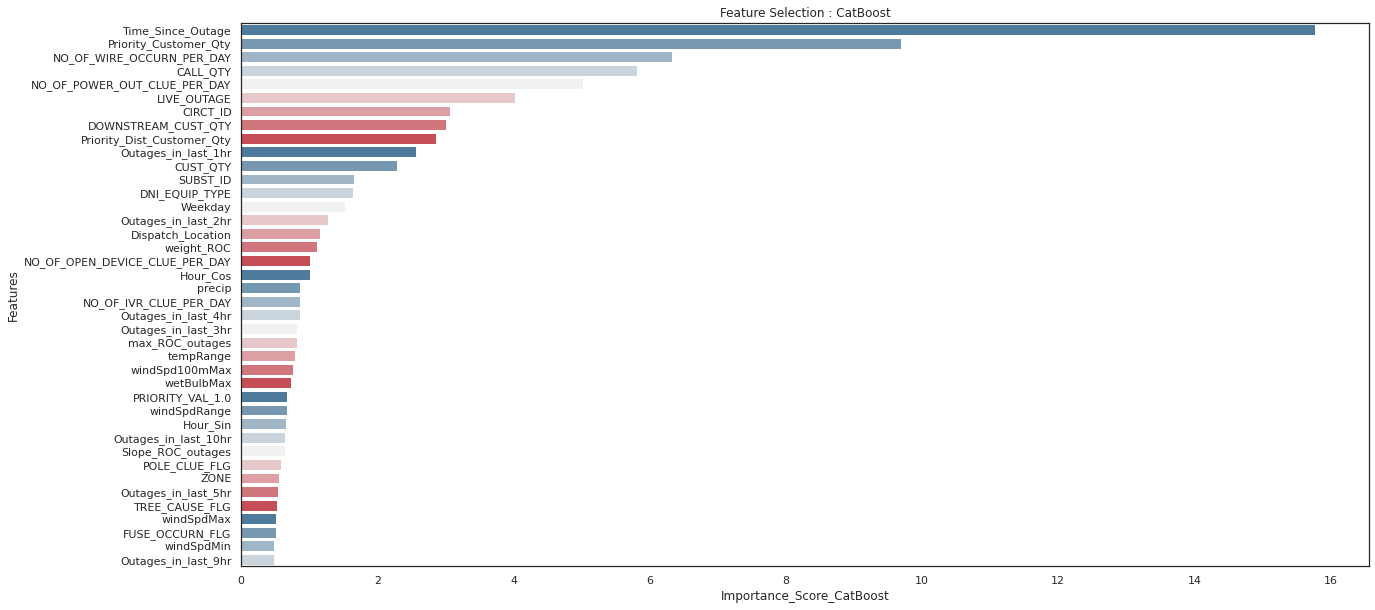

In [14]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_CatBoost", y="Features", data=catboost, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : CatBoost')

In [15]:
final_features = list(catboost.Features)

In [16]:
load_ads.reset_index(drop=True, inplace=True)

## **Train-Test Split using sklearn**

In [57]:
X = load_ads
y = load_ads['TR']

groups = load_ads['OUTAGE_ID']
group_kfold = GroupKFold(n_splits=12)

for train_test_index, hold_index in group_kfold.split(X, y, groups):
    print("TRAIN:", len(train_test_index), "TEST:", len(hold_index))
    print("TRAIN:", train_test_index, "TEST:", hold_index)

print('\n')
print("TRAIN:", train_test_index, "TEST:", hold_index)
print("TRAIN:", len(train_test_index), "TEST:", len(hold_index))
X_train_test, X_hold = X.iloc[train_test_index], X.iloc[hold_index]
y_train_test, y_hold = y.iloc[train_test_index], y.iloc[hold_index]

TRAIN: 506423 TEST: 46039
TRAIN: [     0      1      2 ... 552457 552458 552459] TEST: [    14     15     16 ... 552430 552460 552461]
TRAIN: 506423 TEST: 46039
TRAIN: [     0      1      2 ... 552452 552460 552461] TEST: [    62     63    138 ... 552457 552458 552459]
TRAIN: 506423 TEST: 46039
TRAIN: [     0      1      2 ... 552459 552460 552461] TEST: [   121    122    123 ... 552440 552451 552452]
TRAIN: 506423 TEST: 46039
TRAIN: [     0      1      2 ... 552459 552460 552461] TEST: [    41     42     43 ... 552399 552400 552401]
TRAIN: 506423 TEST: 46039
TRAIN: [     0      1      2 ... 552459 552460 552461] TEST: [    46     47     48 ... 552404 552405 552406]
TRAIN: 506423 TEST: 46039
TRAIN: [     0      1      2 ... 552459 552460 552461] TEST: [    31     32     33 ... 552448 552449 552450]
TRAIN: 506424 TEST: 46038
TRAIN: [     2      3      4 ... 552459 552460 552461] TEST: [     0      1     28 ... 552309 552310 552311]
TRAIN: 506424 TEST: 46038
TRAIN: [     0      1      2 

In [58]:
# train test split sample shape
print(X_train_test.shape)
print(X_hold.shape)

(506424, 161)
(46038, 161)


In [59]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        return True 
    else: 
        return False

In [60]:
print(common_member(list(X_train_test.OUTAGE_ID), list(X_hold.OUTAGE_ID)))

False


In [46]:
X_train_test.reset_index(drop=True, inplace=True)
y_train_test.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.20, random_state=42, shuffle=True)

In [61]:
print(common_member(list(X_train.OUTAGE_ID), list(X_test.OUTAGE_ID)))

True


In [47]:
# hold out sample shape
print(X_hold.shape)

# train test split sample shape
print(X_train.shape, X_test.shape)

(36830, 161)
(412505, 161) (103127, 161)


In [48]:
#Checking the columns having data type as object or boolean
object_columns = X_train.loc[:, (X_train.dtypes == object) | (X_train.dtypes == bool)]
print(list(object_columns.columns))

['STRCTUR_NO', 'EVENT', 'ENERGIZED_DATETIME', 'DNI_EQUIP_TYPE', 'ETR_DATETIME', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITC

In [50]:
#Creating variable with having only categorical features index
categorical_features_indices = np.where((X_train[final_features].dtypes != np.int) & (X_train[final_features].dtypes != np.float))[0];
print(categorical_features_indices)

[12 13 15 27 32 33 35 37]


In [51]:
#Adding Substation id and Circuit id as categorical feature
arr1 = np.array([6, 11])
categorical_features_indices = np.append(arr1, categorical_features_indices)
print(categorical_features_indices)

[ 6 11 12 13 15 27 32 33 35 37]


### **Building Parameter Tuned CatBoost Model**
- CatBoost is an algorithm for gradient boosting on decision trees.

In [52]:
model_col = ['MODEL_NAME' , 'TRAIN_MSE', 'TRAIN_RMSE', 'TRAIN_MAE', 'TRAIN_MAPE', 'TRAIN_R2','TRAIN__Adj_R2', 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2','Test__Adj_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_train_list = pd.DataFrame()
data_test_list = pd.DataFrame()
i=0

In [55]:
cat_base = CatBoostRegressor(silent=True)
cat_base.fit(X_train[final_features], y_train, eval_set=[(X_test[final_features], y_test)], early_stopping_rounds=20, use_best_model=True, cat_features=categorical_features_indices)

y_train_pred = cat_base.predict(X_train[final_features])
y_test_pred = cat_base.predict(X_test[final_features])

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'CATB Baseline', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'CATB Baseline', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CATB Baseline', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [62]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,CATB Baseline,18880.25,137.41,96.67,377.19,0.93,0.93,20387.03,142.78,100.08,367.39,0.92,0.92


## **CatBoost Base: Actual vs Fitted Plot**

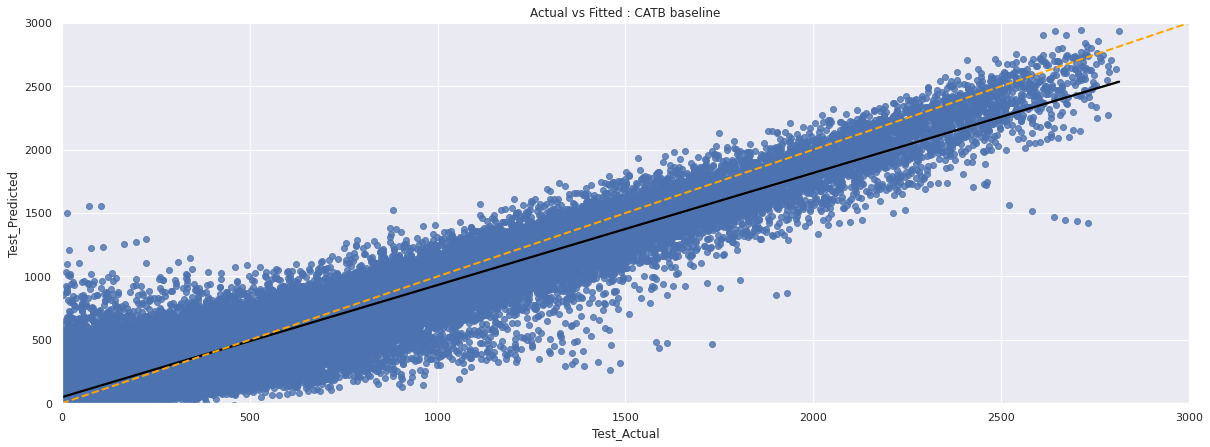

In [63]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CATB Baseline'], line_kws={"color": "black"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CATB baseline')
points = np.linspace(0, 7000, 100)
ax = sns.lineplot(points, points, color='orange', marker=None,linestyle='--', linewidth=2.0)

In [64]:
storm_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
reprediction_result_df = pd.DataFrame(columns=storm_col)
reprediction_test_list = pd.DataFrame() 
i=0

In [68]:
X = X_hold[final_features]
y = y_hold

y_hold_pred = cat_base.predict(X)

mse_test = mean_squared_error(y, y_hold_pred)
rmse_test = rmse(y,y_hold_pred)
mae_test = mean_absolute_error(y, y_hold_pred)
mape_test = mean_absolute_percentage_error(y,y_hold_pred)
r2_test = r2_score(y,y_hold_pred)

data_test = pd.DataFrame({'Model':'CatBoost', 'Test_Predicted': list(y_hold_pred),'Test_Actual': list(y)})
reprediction_test_list = reprediction_test_list.append(data_test)
reprediction_test_list.reset_index(drop=True, inplace=True)

reprediction_result_df.loc[i] = ['CatBoost', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [69]:
reprediction_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,CatBoost,39914.67,199.79,120.72,391.31,0.85


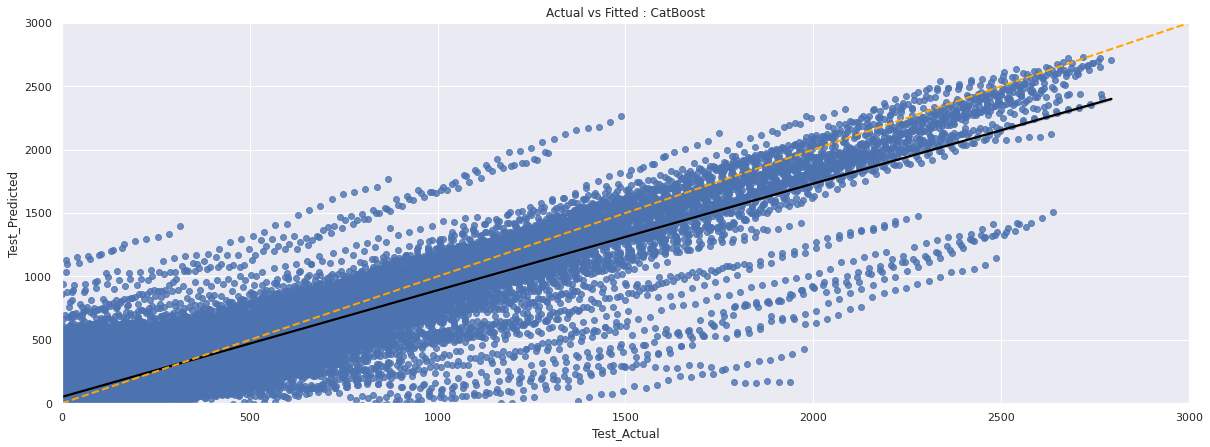

In [70]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=reprediction_test_list[reprediction_test_list.Model=='CatBoost'], line_kws={"color": "black"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CatBoost')
points = np.linspace(0, 7000, 100)
ax = sns.lineplot(points, points, color='orange', marker=None,linestyle='--', linewidth=2.0)

### **Randomized Search using CatBoost**

In [ ]:
grid_params = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)],
               'depth': [int(x) for x in np.linspace(3, 10, num = 5)],
               'l2_leaf_reg': [3,4,5,6],
               'leaf_estimation_iterations': [1,2,3,4]}

In [ ]:
%%time
cat_ran = CatBoostRegressor(silent=True)

cat_random = RandomizedSearchCV(estimator=cat_ran, param_distributions=grid_params, cv = group_kfold, n_iter=30, verbose=True, n_jobs=-1)

cat_random.fit(X_train[final_features], y_train, eval_set=[(X_val[final_features], y_val)], early_stopping_rounds=50, cat_features=categorical_features_indices)

In [ ]:
print(cat_random.best_params_)

In [ ]:
df_results = pd.DataFrame(cat_random.cv_results_)

with open('best_params_site.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in cat_random.best_params_.items():
        writer.writerow([key, value])

with open("best_score_site.txt", "w") as txtfile:
    txtfile.write(f"Best Score = {cat_random.best_score_}")

print(cat_random.best_params_)
print(cat_random.best_score_)

In [ ]:
cat_rs = CatBoostRegressor(silent=True)
cat_rs.set_params(**cat_random.best_params_)
cat_rs.fit(X_train[final_features], y_train, eval_set=[(X_val[final_features], y_val)], early_stopping_rounds=50, use_best_model=True, cat_features=categorical_features_indices)

y_train_pred = cat_rs.predict(X_train[final_features])
y_hold_pred = cat_rs.predict(X_hold[final_features])

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_hold, y_hold_pred)
rmse_test = rmse(y_hold,y_hold_pred)
mae_test = mean_absolute_error(y_hold, y_hold_pred)
mape_test = mean_absolute_percentage_error(y_hold,y_hold_pred)
r2_test = r2_score(y_hold,y_hold_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'CATB RS', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'CATB RS', 'Test_Predicted': list(y_hold_pred),'Test_Actual': list(y_hold)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CATB RS', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [ ]:
model_result_df.head()

## **CatBoost Random Search: Actual vs Fitted PLot**

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CATB RS'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CATB RS')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

## **Save Model Object**

In [ ]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/IPL_TTR_Catboost_12072020.pkl', 'wb') as f:
    pickle.dump(cat_rs, f)

## **Better Visualization**

In [ ]:
data_test_list

In [ ]:
def segment_storm(x):
    if(x<=120):
        return "0-120", 1
    elif(x<=240):
        return "120-240", 2
    elif(x<=360):
        return "240-360", 3
    elif(x<=480):
        return "360-480", 4
    elif(x<=600):
        return "480-600", 5
    elif(x<=720):
        return "600-720", 6
    elif(x<=840):
        return "720-840", 7
    elif(x<=960):
        return "840-960", 8
    elif(x<=1080):
        return "960-1080", 9
    elif(x<=1200):
        return "1080-1200", 10
    elif(x<=1320):
        return "1200-1320", 11
    elif(x<=1440):
        return "1320-1440", 12
    else:
        return ">1440", 13
    
data_test_list['Actual_Bucket'], data_test_list['size'] = zip(*data_test_list['Test_Actual'].apply(segment_storm))

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=data_test_list[data_test_list.Model=='CATB RS'], x="Test_Predicted", y="Test_Actual", hue="Actual_Bucket", size="size", sizes=(30, 100))
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:14],l[0:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actual vs Predicted')

## **2020 out of Sample Validation**

In [ ]:
from scipy.stats import linregress

# load 2020 dataset
df_ads_2020 = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_2020_11162020.csv')
df_ads_2020['Time_Since_Outage'] = 0

# add features
def feature_add(group):
    group = group.reset_index(drop = True)
    x = [group.Outages_in_last_1hr[0],group.Outages_in_last_2hr[0],group.Outages_in_last_3hr[0],group.Outages_in_last_4hr[0],group.Outages_in_last_5hr[0]
        ,group.Outages_in_last_6hr[0],group.Outages_in_last_7hr[0],group.Outages_in_last_8hr[0],group.Outages_in_last_9hr[0],group.Outages_in_last_10hr[0]]
    y = [1,2,3,4,5,6,7,8,9,10]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    group['Slope_outages'] = slope
    
    ROC = [abs(group.Outages_in_last_1hr[0] - group.Outages_in_last_2hr[0]),abs(group.Outages_in_last_2hr[0] - group.Outages_in_last_3hr[0]),
           abs(group.Outages_in_last_3hr[0] - group.Outages_in_last_4hr[0]),abs(group.Outages_in_last_4hr[0] - group.Outages_in_last_5hr[0]),
           abs(group.Outages_in_last_5hr[0] - group.Outages_in_last_6hr[0]),abs(group.Outages_in_last_6hr[0] - group.Outages_in_last_7hr[0]),
           abs(group.Outages_in_last_7hr[0] - group.Outages_in_last_8hr[0]),abs(group.Outages_in_last_8hr[0] - group.Outages_in_last_9hr[0]),
           abs(group.Outages_in_last_9hr[0] - group.Outages_in_last_10hr[0])]
    y = [1,2,3,4,5,6,7,8,9]
    slope, intercept, r_value, p_value, std_err = linregress(ROC, y)
    group['Slope_ROC_outages'] = slope
    
    group['max_ROC_outages'] = max(ROC)
    group['max_index_ROC'] = 1+ROC.index(max(ROC))    
    group['weight_ROC'] = group['max_ROC_outages'] * group['max_index_ROC']*0.1
    return group

In [ ]:
df_ads_2020 = df_ads_2020.groupby(['OUTAGE_ID'], as_index = False).apply(feature_add).reset_index(drop = True)
df_ads_2020 = df_ads_2020.dropna(axis=0, subset=['Slope_outages', 'Slope_ROC_outages'])
df_ads_2020 = df_ads_2020[df_ads_2020.TTR>30]
df_ads_2020 = df_ads_2020[df_ads_2020.TTR<5000]

In [ ]:
storm_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
storm_result_df = pd.DataFrame(columns=storm_col)
storm_test_list = pd.DataFrame() 
i=0

In [ ]:
df_ads_2020['CIRCT_ID'] = df_ads_2020['CIRCT_ID'].astype(int)
df_ads_2020['SUBST_ID'] = df_ads_2020['SUBST_ID'].astype(int)

In [ ]:
X = df_ads_2020[final_features]
y = df_ads_2020.TTR

y_test_pred = cat_rs.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost2020', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['CatBoost2020', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [ ]:
storm_result_df

In [ ]:
def segment_storm(x):
    if(x<=120):
        return "0-120", 1
    elif(x<=240):
        return "120-240", 2
    elif(x<=360):
        return "240-360", 3
    elif(x<=480):
        return "360-480", 4
    elif(x<=600):
        return "480-600", 5
    elif(x<=720):
        return "600-720", 6
    elif(x<=840):
        return "720-840", 7
    elif(x<=960):
        return "840-960", 8
    elif(x<=1080):
        return "960-1080", 9
    elif(x<=1200):
        return "1080-1200", 10
    elif(x<=1320):
        return "1200-1320", 11
    elif(x<=1440):
        return "1320-1440", 12
    else:
        return ">1440", 13
    
storm_test_list['Actual_Bucket'], storm_test_list['size'] = zip(*storm_test_list['Test_Actual'].apply(segment_storm))

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=storm_test_list[storm_test_list.Model=='CatBoost2020'], x="Test_Predicted", y="Test_Actual", hue="Actual_Bucket", size="size", sizes=(30, 100))
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:14],l[0:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actual vs Predicted')